Prepared by Vladimir Zaigrajew and Tymoteusz Kwieciński

# Exercise Week 5 - Interpretable Representation Learning
In the previous exercise, we trained our first (maybe) self-supervised learning (SSL) model using rotation as a pretext task. Later, on a dataset of road signs, you tested how a fine-tuned SSL model performed comparably to a model trained from scratch with respect to the downstream task evaluation (road sign prediction). You could evaluate which supervised or self-supervised approach is better when we have a small amount of labeled data but a decent amount of unlabeled data. You also learned two evaluation methods in this task: using linear probing (freezing the model and training a classifier with features extracted from the SSL model) and fine-tuning on various downstream tasks.

Next, you explored two other popular evaluation methods: using UMAP and t-SNE to map high-dimensional features to 2D space and visualize them, which enables visual understanding of how samples are distributed and how linear probing can be successful. The second approach is an alternative to linear probing, using a KNN classifier to evaluate the features extracted from the model. In the previous exercise, you evaluated models like a pro on several downstream tasks and datasets.

Now for the last exercise, the cherry on the cake, this exercise is an ensemble of previous exercises where you will train your SSL model alongside a model from scratch and evaluate the features from both models on other downstream tasks with tools learned from previous exercises. However, now we are getting our hands on an SSL method which is well established in the SSL world and which you should already know from our lectures: [SimCLR](https://arxiv.org/abs/2002.05709). Your task will be to train two SSL models on the dataset with road signs alongside a model trained from scratch. We will be using an even smaller classification dataset than previously, and you will train models and compare them. To check everything we've done in previous exercises, we will also test how features from our models transfer to two other downstream tasks.

So let's start!

## Part I. Prepare the environment
Firstly, prepare an environment by installing all the required libraries. To know which packages to install, you need to investigate cells with the import statements. In today's exercise, you will learn about a cool wrapper for PyTorch called `pytorch_lightning` which makes training and writing code easier :). I require you to paste the code below with the command to install the libraries with **specific versions**, for example:
```python
%pip install numpy==1.21.0 pandas==1.3.0 matplotlib==3.4.2 torch==1.9.0 torchvision==0.10.0 pytorch-lightning==1.4.9 scikit-learn==0.24.2 umap-learn==0.5.2
```

In [11]:
import os
import time
import umap
import random
import numpy as np
from tqdm import tqdm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


import torch
import torch.nn.functional as F
import pytorch_lightning as pl

import torchmetrics
import torchvision
from torchvision import transforms as T

import matplotlib.pyplot as plt

As a task requiring you to implement the SimCLR model yourself would be interesting (or not because this one is fairly simple), we will leverage in this task another library called `lightly` which provides architectures and needed pipeline functions for various SSL models. In this exercise, we will adapt this tutorial from the [lightly library](https://docs.lightly.ai/self-supervised-learning/tutorials/package/tutorial_simclr_clothing.html) to implement SimCLR in our code.

In [13]:
from lightly.transforms import SimCLRTransform, utils

d:\Repos\Warsztaty_Badawcze\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Now for a very important part: making results reproducible by seeding the random number generators. In the code below, we set all the random number generators to the same seed. This is crucial for the reproducibility of results. You can change the seed to any number you want, but make sure to set it to the same number in all cells where random operations occur. For those who are still unfamiliar with this concept, understanding random seeding is essential knowledge for ML practitioners. Setting a fixed seed ensures that random operations (like weight initialization, data shuffling, etc.) produce the same results each time the code is run, which allows for consistent and comparable experiments.

In [14]:
# seed everything for reproducibility
SEED = 42

def seed_everything(seed: int=42):
    pl.seed_everything(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    ####### Normaly you would also need to seed those generators but `pytorch_lightning` does it in one func
    # random.seed(seed)
    # np.random.seed(seed)
    # torch.manual_seed(seed)
    ######
    torch.cuda.manual_seed(seed) # Don't know if pytorch lightning does this
    torch.cuda.manual_seed_all(seed) # Don't know if pytorch lightning does this
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(SEED)

Seed set to 42


## Part II. Prepare the data

Now, we need to prepare the data. In this exercise, similar to what was done two exercises ago, we will focus on the `GTSRB` dataset that consists of road sign images and their corresponding classes. The dataset contains 43 classes of traffic signs, with a total of approximately 50,000 images. The images are in color, and we will resize them to 224x224 pixels. The dataset is split into training and test sets, with about 39,209 images in the training set and 12,630 images in the test set. We will use **90%** of the training set for training our SSL models and the remaining **10%** for the classification task. The test set will be used for the evaluation of all models.

To implement this, we will first download the dataset and create various preprocessed versions of it. We will create two versions of the `GTSRB` dataset with custom preprocessing required for our SSL models (consider why this specific preprocessing is needed). Additionally, we will also create training subsets and test datasets for the classification task. You don't need to implement anything here - just explore the code and run it.

In [16]:
# define the transform to apply to the data
# First the rotation transform
rotation_transform = T.v2.Compose(
    [
        T.RandomResizedCrop((224, 224)),
        T.v2.ToImage(),
        T.v2.ToDtype(torch.float32, scale=True),
        T.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        )
    ]
)
# Now the transform for the SimCLR model
simclr_transform = SimCLRTransform(input_size=(224, 224), vf_prob=0.5, rr_prob=0.5)
# Now the transform for the classification model
scratch_transform = T.v2.Compose(
    [
        T.RandomResizedCrop((224, 224)),
        T.RandomHorizontalFlip(),
        T.v2.ToImage(),
        T.v2.ToDtype(torch.float32, scale=True),
        T.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        )
    ]
)
# Now the transform for the test dataset
test_transform = T.v2.Compose(
    [
        T.Resize((224, 224)),
        T.v2.ToImage(),
        T.v2.ToDtype(torch.float32, scale=True),
        T.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        )
    ]
)

# Load the datasets
path_where_data_is_stored = '../data' # change this to the path where you want to store the data

# Load the GTSRB dataset
train_rotation_dataset = torchvision.datasets.GTSRB(root=path_where_data_is_stored, split="train", transform=rotation_transform, download=True)
test_rotation_dataset = torchvision.datasets.GTSRB(root=path_where_data_is_stored, split="test", transform=rotation_transform, download=True)

train_simclr_dataset = torchvision.datasets.GTSRB(root=path_where_data_is_stored, split="train", transform=simclr_transform, download=True)
test_simclr_dataset = torchvision.datasets.GTSRB(root=path_where_data_is_stored, split="test", transform=simclr_transform, download=True)

train_dataset = torchvision.datasets.GTSRB(root=path_where_data_is_stored, split="train", transform=scratch_transform, download=True)

test_dataset = torchvision.datasets.GTSRB(root=path_where_data_is_stored, split="test", transform=test_transform, download=True)

# Lets now split the dataset into a SSL dataset and a classification dataset
SSL_SIZE = 0.9 # percentage of the dataset to use for training
targets = np.array([y for _, y in train_rotation_dataset])
SSL_indices, classification_indices = train_test_split(
    np.arange(len(targets)),
    test_size=1-SSL_SIZE,
    random_state=SEED,
    stratify=targets
)
train_rotation_dataset = torch.utils.data.Subset(train_rotation_dataset, SSL_indices)
train_simclr_dataset = torch.utils.data.Subset(train_simclr_dataset, SSL_indices)
train_dataset = torch.utils.data.Subset(train_dataset, classification_indices)

print(f"Number of samples in the train dataset: {len(train_dataset)}")
print(f"Number of samples in the test dataset: {len(test_dataset)}")
print(f"Number of samples in the train rotation dataset: {len(train_rotation_dataset)}")
print(f"Number of samples in the train simclr dataset: {len(train_simclr_dataset)}")

d:\Repos\Warsztaty_Badawcze\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Number of samples in the train dataset: 2664
Number of samples in the test dataset: 12630
Number of samples in the train rotation dataset: 23976
Number of samples in the train simclr dataset: 23976


In [17]:
map_idx_to_class = [
    "Speed limit (20km/h)",
    "Speed limit (30km/h)",
    "Speed limit (50km/h)",
    "Speed limit (60km/h)",
    "Speed limit (70km/h)",
    "Speed limit (80km/h)",
    "End of speed limit (80km/h)",
    "Speed limit (100km/h)",
    "Speed limit (120km/h)",
    "No passing",
    "No passing for vehicles over 3.5 metric tons",
    "Right-of-way at the next intersection",
    "Priority road",
    "Yield",
    "Stop",
    "No vehicles",
    "Vehicles over 3.5 metric tons prohibited",
    "No entry",
    "General caution",
    "Dangerous curve to the left",
    "Dangerous curve to the right",
    "Double curve",
    "Bumpy road",
    "Slippery road",
    "Road narrows on the right",
    "Road work",
    "Traffic signals",
    "Pedestrians",
    "Children crossing",
    "Bicycles crossing",
    "Beware of ice/snow",
    "Wild animals crossing",
    "End of all speed and passing limits",
    "Turn right ahead",
    "Turn left ahead",
    "Ahead only",
    "Go straight or right",
    "Go straight or left",
    "Keep right",
    "Keep left",
    "Roundabout mandatory",
    "End of no passing",
    "End of no passing by vehicles over 3.5 metric tons"
]
angles = [0, 90, 180, 270]

At this point, we have the original `GTSRB` dataset containing images and labels. We divided the training set into three parts: `train_rotation_dataset`, `train_simclr_dataset`, and `train_dataset` (classification dataset). The `train_dataset` will be used for the classification task, while the other two will be used for different SSL tasks. For SimCLR, we don't need to modify the dataset structure itself, as the `simclr_transform` already applies all needed modifications during training. However, for the rotation task, we need to prepare the dataset with random rotations. We've provided the class `SSLRot` which, unlike in the previous exercise where you needed to implement it yourself, you can now just relax and explore to understand how it works.

In [18]:
# Rotation Dataset
class SSLRot(torch.utils.data.Dataset):
    def __init__(self, dataset: torch.utils.data.Dataset, angles: list[int]):
        super(SSLRot, self).__init__()
        self.original_dataset = dataset
        self.angles = angles

    def __len__(self):
        return len(self.original_dataset)
    
    def rand_rotate(self, img: torch.Tensor) -> tuple[torch.Tensor, int]:
        """
        Randomly rotates the image by 0, 90, 180, or 270 degrees.

        Args:
            img (torch.Tensor): Input image tensor of shape (C, H, W).

        Returns:
            tuple: Rotated image tensor and the corresponding rotation label (0, 1, 2, or 3).
        """
        rot_label = random.randint(0, 3) 
        rotated_img = T.functional.rotate(img, self.angles[rot_label])
        return rotated_img, rot_label

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        # Get the data from the original dataset and ignore the label (second element)
        img, _ = self.original_dataset[idx]
        rotated_img, rot_label = self.rand_rotate(img)
        return rotated_img, torch.tensor(rot_label, dtype=torch.long)

Let's visualize what the dataset looks like. We'll display some examples from our rotation-based SSL dataset. If you happen to get all 4 images rotated by 0 degrees, just rerun the cell. Even though we set a random seed for reproducibility, the specific rotation operations might not be entirely deterministic depending on implementation details, so you should see some variety in the rotations.

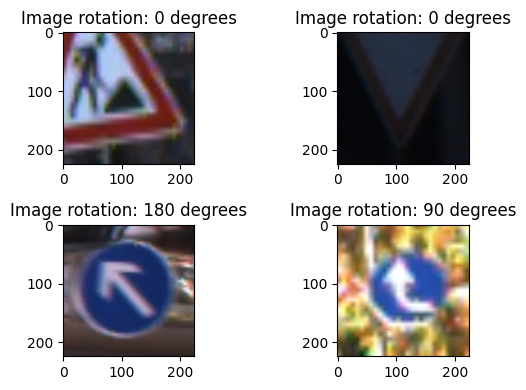

In [19]:
train_rotation_dataset = SSLRot(train_rotation_dataset, angles)
test_rotation_dataset = SSLRot(test_dataset, angles)

fig, ax = plt.subplots(2, 2, figsize=(6, 4))
img, rot = train_rotation_dataset[0]
img = img.numpy().transpose((1, 2, 0))
img = utils.IMAGENET_NORMALIZE["std"] * img + utils.IMAGENET_NORMALIZE["mean"]
img = np.clip(img, 0, 1)
ax[0, 0].imshow(img)
ax[0, 0].set_title(f"Image rotation: {angles[rot]} degrees")

img, rot = train_rotation_dataset[1]
img = img.numpy().transpose((1, 2, 0))
img = utils.IMAGENET_NORMALIZE["std"] * img + utils.IMAGENET_NORMALIZE["mean"]
img = np.clip(img, 0, 1)
ax[0, 1].imshow(img)
ax[0, 1].set_title(f"Image rotation: {angles[rot]} degrees")

img, rot = test_rotation_dataset[2]
img = img.numpy().transpose((1, 2, 0))
img = utils.IMAGENET_NORMALIZE["std"] * img + utils.IMAGENET_NORMALIZE["mean"]
img = np.clip(img, 0, 1)
ax[1, 0].imshow(img)
ax[1, 0].set_title(f"Image rotation: {angles[rot]} degrees")

img, rot = test_rotation_dataset[3]
img = img.numpy().transpose((1, 2, 0))
img = utils.IMAGENET_NORMALIZE["std"] * img + utils.IMAGENET_NORMALIZE["mean"]
img = np.clip(img, 0, 1)
ax[1, 1].imshow(img)
ax[1, 1].set_title(f"Image rotation: {angles[rot]} degrees")
plt.tight_layout()
plt.show()

# Part III. Load, modify and prepare training pipelines with ResNet18

Now, we need to get the model. In the previous exercise, we used the `ResNet18` model from `torchvision`. This time we will use the same model, but we will modify it for different purposes: first to predict the rotation of the image as a self-supervised task, then to implement SimCLR, and finally to predict classes from the original dataset. The `ResNet18` model is a convolutional neural network (CNN) that is widely used for image classification tasks. It consists of 18 layers with residual connections (skip connections) that help address the vanishing gradient problem in deep networks, allowing it to learn rich representations from images efficiently.

In [20]:
def load_resnet(number_of_classes: int | None = None) -> torch.nn.Module:
    model = torchvision.models.resnet18(pretrained=False)
    if number_of_classes is not None:
        model.fc = torch.nn.Linear(model.fc.in_features, number_of_classes)
    return model

def test_load_resnet():
    model = load_resnet(len(map_idx_to_class))
    x, y = test_dataset[0]
    x = x.unsqueeze(0)  # Add a batch dimension
    y = torch.tensor(y).unsqueeze(0)  # Add a batch dimension
    
    with torch.no_grad():
        pred_y = model(x)
        
    loss = F.cross_entropy(pred_y, y)
    pred_y_class = torch.argmax(pred_y, dim=1)
    print(f"Input shape: {x.shape}, Model output: {pred_y.shape}, Model predicted {pred_y_class}, Ground truth: {y}, Loss: {loss.item()}")

test_load_resnet()

Input shape: torch.Size([1, 3, 224, 224]), Model output: torch.Size([1, 43]), Model predicted tensor([5]), Ground truth: tensor([16]), Loss: 4.123642444610596


d:\Repos\Warsztaty_Badawcze\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Repos\Warsztaty_Badawcze\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Now your coding task begins. Based on the tutorial from [lightly](https://docs.lightly.ai/self-supervised-learning/tutorials/package/tutorial_simclr_clothing.html), your task is to implement the `SimCLRModel` class using the PyTorch Lightning framework. This class will implement the SimCLR approach for self-supervised learning.

The documentation and the class header will guide you through what needs to be implemented, but here are some hints:
1. You'll need to use the ResNet18 backbone and modify it for the SimCLR approach
2. Pay attention to how the projection head is implemented in SimCLR
3. Follow the PyTorch Lightning structure with appropriate training_step, configure_optimizers, etc.
4. The NT-Xent (normalized temperature-scaled cross entropy) loss function is key for SimCLR

I believe you can implement this without too much additional help by following the tutorial from lightly and examining the class header. Good luck!

In [21]:
class SimCLRModel(pl.LightningModule):
    def __init__(self, lr: float = 6e-2, weight_decay: float = 5e-4, max_epochs: int = 100):
        pass

If you're having difficulty implementing the SimCLR model, you can draw inspiration from the provided implementations of the rotation and classification Lightning models below. 

Importantly, there's a bug in how the training progress is logged in these implementations. Part of your task is to identify and fix this bug to ensure clear visualization of the training progress. Look carefully at how metrics are logged during training and validation steps, and check if there might be inconsistencies in naming, duplicate logging, or incorrect value calculations that could affect the training visualization.

In [22]:
class RotationModel(pl.LightningModule):
    def __init__(self, lr: float = 6e-2, weight_decay: float = 5e-4, max_epochs: int = 100, num_classes: int = 4):
        super().__init__()
        self.model = load_resnet(num_classes)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.lr = lr
        self.weight_decay = weight_decay
        self.max_epochs = max_epochs
        self.save_hyperparameters(ignore=["model"])
        
        # Add metrics for evaluation
        self.metric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.train_acc = []
        self.val_acc = []
        self.test_acc = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        
        preds = torch.argmax(y_hat, dim=1)
        acc = self.metric(preds, y)    
    
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        
        return loss
    
    def on_train_epoch_end(self):
        self.train_acc.append(self.metric.compute())
        self.log("train_acc_epoch", self.metric.compute(), prog_bar=True)
        self.metric.reset()
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        
        # Calculate and log validation accuracy
        preds = torch.argmax(y_hat, dim=1)
        acc = self.metric(preds, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        
        return loss
    
    def on_validation_epoch_end(self):
        self.val_acc.append(self.metric.compute())
        self.log("val_acc_epoch", self.metric.compute(), prog_bar=True)
        self.metric.reset()
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        
        # Calculate and log test accuracy
        preds = torch.argmax(y_hat, dim=1)
        acc = self.metric(preds, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        
        return loss
    
    def on_test_epoch_end(self):
        self.test_acc.append(self.metric.compute())
        self.log("test_acc_epoch", self.metric.compute(), prog_bar=True)
        self.metric.reset()

    def configure_optimizers(self):
        optim = torch.optim.AdamW(
            self.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, self.max_epochs)
        return [optim], [scheduler]

In [23]:
class ClassifierModel(pl.LightningModule):
    def __init__(self,  model: torch.nn.Module, lr: float = 6e-2, weight_decay: float = 5e-4, max_epochs: int = 100):
        super().__init__()
        self.model = model
        self.criterion = torch.nn.CrossEntropyLoss()
        self.lr = lr
        self.weight_decay = weight_decay
        self.max_epochs = max_epochs
        self.save_hyperparameters(ignore=["model"])
        
        # Add metrics for evaluation
        self.metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(map_idx_to_class))
        self.train_acc = []
        self.val_acc = []
        self.test_acc = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        
        preds = torch.argmax(y_hat, dim=1)
        acc = self.metric(preds, y)
        
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        return loss

    def on_train_epoch_end(self):
        self.train_acc.append(self.metric.compute())
        self.log("train_acc_epoch", self.metric.compute(), prog_bar=True)
        self.metric.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        
        # Calculate and log validation accuracy
        preds = torch.argmax(y_hat, dim=1)
        acc = self.metric(preds, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

        return loss
    
    def on_validation_epoch_end(self):
        self.val_acc.append(self.metric.compute())
        self.log("val_acc_epoch", self.metric.compute(), prog_bar=True)
        self.metric.reset()
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        

        preds = torch.argmax(y_hat, dim=1)
        acc = self.metric(preds, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)

        return loss
    
    def on_test_epoch_end(self):
        self.test_acc.append(self.metric.compute())
        self.log("test_acc_epoch", self.metric.compute(), prog_bar=True)
        self.metric.reset()

    def configure_optimizers(self):
        optim = torch.optim.AdamW(
            self.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, self.max_epochs)
        return [optim], [scheduler]

And lastly, here's our visualization method to display examples from the dataset alongside their ground truth labels and model predictions. This will help us visually evaluate how well our models are performing and understand any patterns in their predictions.

In [24]:
def visualize_predictions(model: torch.nn.Module, dataset: torch.utils.data.Dataset, device: torch.device, class_names: list[str], num_images: int=5):
    """Visualize predictions of the model on a subset of the dataset.
    Args:
        model (torch.nn.Module): The model to use for predictions.
        dataset (torch.utils.data.Dataset): The dataset to visualize.
        device (torch.device): The device to use for predictions (CPU or GPU).
        class_names (list[str]): The list of class names.
        num_images (int): The number of images to visualize.
        
    """
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    
    _, axes = plt.subplots(1, num_images, figsize=(15, 5))
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, label = dataset[idx]
            input = img.unsqueeze(0).to(device)
            output = model(input)
            pred_label = output.argmax(dim=1).item()
            
            img = img.numpy().transpose((1, 2, 0))
            img = utils.IMAGENET_NORMALIZE["std"] * img + utils.IMAGENET_NORMALIZE["mean"]
            img = np.clip(img, 0, 1)
            
            axes[i].imshow(img)
            axes[i].set_title(f"Pred: {class_names[pred_label]}\nTrue: {class_names[label]}")
            axes[i].axis('off')
    
    plt.show()

# Part IV. Training SimCLR model

Let's now train our models. First, we will start with training the SimCLR model `SimCLRModel` on our `train_simclr_dataset` using the PyTorch Lightning `Trainer` (I think you'll really appreciate its simplicity and power).

PyTorch Lightning abstracts away much of the training loop boilerplate, letting you focus on the model architecture and logic. The `Trainer` handles device management, logging, checkpointing, and many other training details automatically.

We encourage you to experiment with different parameters and see how they affect the training process. Increasing the batch_size and number of epochs can lead to better representations, but be mindful of memory usage and training time. Adjust these parameters based on your hardware capabilities and monitor the training performance. That's why we advise using Google Colab with GPU for this exercise.

Some parameters you might want to experiment with:
- Learning rate
- Batch size
- Number of epochs

In [25]:
### PARAMETERS ###
BATCH_SIZE = 256
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
NUM_WORKERS = 8
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [27]:
# Get the data loaders
dl_train_simclr = torch.utils.data.DataLoader(
    train_simclr_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
dl_eval_simclr = torch.utils.data.DataLoader(
    test_simclr_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

# Prepare the model
simclr_model = SimCLRModel(lr=LEARNING_RATE, max_epochs=NUM_EPOCHS)

# Prepare the trainer for pytorch lightning
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, devices=1, accelerator=device)

# Train the model
trainer.fit(simclr_model, dl_train_simclr, dl_eval_simclr)


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\Repos\Warsztaty_Badawcze\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


AttributeError: 'SimCLRModel' object has no attribute '_compiler_ctx'

Let's now view the results of our model training by plotting the loss curves for both train and validation sets. This will help us understand how the model learning progressed and whether there are signs of overfitting or underfitting.

In [ ]:
fig, ax = simclr_model.metric.plot(simclr_model.train_loss)
fig.suptitle('Training Accuracy on Rotation Dataset')
fig, ax = simclr_model.metric.plot(simclr_model.val_loss)
fig.suptitle('Validation Accuracy on Rotation Dataset')
plt.show()

In [ ]:
# Save the model for later
simclr_model = simclr_model.backbone

With PyTorch Lightning, you can easily log the training progress and visualize it using TensorBoard. You can use the following command to start TensorBoard in your notebook:
```python
%load_ext tensorboard
%tensorboard --logdir lightning_logs/
```
While we won't use TensorBoard in this exercise, it's a powerful tool for visualizing training metrics, model graphs, distributions of weights and biases, and much more. You're encouraged to explore it in your own projects.

# Part V. Training Rotation model

Let's now move on to train our rotation model `RotationModel` on the `train_rotation_dataset` with the same PyTorch Lightning trainer. The hyperparameters are the same as for the SimCLR model to maintain consistency in our comparison. You can also experiment with different parameters and see how they affect the training process.

The training process is similar to the one we used for the SimCLR model, but we're using a different dataset (with rotated images) and a different model architecture tailored for the rotation prediction task. While both approaches are self-supervised, they learn representations in fundamentally different ways - SimCLR through contrastive learning of similar pairs, and the rotation model through predicting geometric transformations.

In [ ]:
### PARAMETERS ###
BATCH_SIZE = 64
NUM_EPOCHS = 12
LEARNING_RATE = 0.001
NUM_WORKERS = 0
NUMBER_OF_CLASSES = 4
device = "mps"
print(f"Using device: {device}")

In [ ]:
# Get the data loaders
dl_train_rotation = torch.utils.data.DataLoader(
    train_rotation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
dl_eval_rotation = torch.utils.data.DataLoader(
    test_rotation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

# Prepare the model
rotation_model = RotationModel(lr=LEARNING_RATE, max_epochs=NUM_EPOCHS, num_classes=NUMBER_OF_CLASSES)

# Prepare the trainer for pytorch lightning
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, devices=-1, accelerator=device)

# Train the model
trainer.fit(rotation_model, dl_train_rotation, dl_eval_rotation)

In [ ]:
fig, ax = rotation_model.metric.plot(rotation_model.train_acc)
fig.suptitle('Training Accuracy on Rotation Dataset')
fig, ax = rotation_model.metric.plot(rotation_model.val_acc)
fig.suptitle('Validation Accuracy on Rotation Dataset')
plt.show()

In [ ]:
rotation_model = rotation_model.model
rotation_model = rotation_model.to(device)

In [ ]:
visualize_predictions(rotation_model, test_rotation_dataset, num_images=5, device=device, class_names=angles)

# Part VI. Training Classification model from scratch

And the last model we are going to train is our classification model with random initialization (from scratch). We will train the `ClassificationModel` on the `train_dataset` with the same trainer. This model will serve as our baseline for comparison with the SSL-pretrained models we'll develop later.

Training a model from scratch on the classification task will help us evaluate how effective our self-supervised pre-training methods are compared to the traditional supervised approach. We will also evaluate this model's performance on the test dataset to establish a baseline accuracy for our later comparisons.

In [ ]:
### PARAMETERS ###
BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
NUM_WORKERS = 0
NUMBER_OF_CLASSES = 43
device = "mps"
print(f"Using device: {device}")

In [ ]:
# Get the data loaders
dl_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
dl_eval = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

# Prepare the model
scratch_model = ClassifierModel(model=load_resnet(NUMBER_OF_CLASSES), lr=LEARNING_RATE, max_epochs=NUM_EPOCHS)

# Prepare the trainer for pytorch lightning
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, devices=-1, accelerator=device)

# Train the model
trainer.fit(scratch_model, dl_train, dl_eval)

In [ ]:
fig, ax = scratch_model.metric.plot(scratch_model.train_acc)
fig.suptitle('Training and Validation Accuracy on Classification Dataset')
fig, ax = scratch_model.metric.plot(scratch_model.val_acc)
fig.suptitle('Training and Validation Accuracy on Classification Dataset')
plt.show()

In [ ]:
scratch_model = scratch_model.model
scratch_model = scratch_model.to(device)

In [ ]:
visualize_predictions(scratch_model, test_dataset, num_images=5, device=device, class_names=map_idx_to_class)

# Part VII. Let's evaluate the SSL models on the downstream task

Now we will evaluate our SSL models on the downstream task of road sign image classification. We will use two common approaches to transfer learning from self-supervised models: linear probing and fine-tuning.

## Linear Probing
With linear probing, we will freeze the feature extraction backbone of our SSL models (preventing any weight updates) and train only a simple linear classifier on top of the extracted features. This approach tests how well the representations learned during self-supervised training transfer to the new task without any adaptation. Our `ClassifierModel` class already handles this by allowing us to freeze the backbone model before training.

## Fine-Tuning
With fine-tuning, we start with the same pre-trained model but allow the entire network (both backbone and classifier) to be updated during training. This approach allows the model to adapt its representations specifically for the downstream task. We'll use our `ClassificationModel` class for this approach as well, but without freezing the backbone.

For both approaches, we will use the same trainer as before, but this time we will use the `train_dataset` for training and `test_dataset` for evaluation. This will allow us to directly compare:
1. A model trained from scratch
2. Linear probing of our rotation-based SSL model
3. Linear probing of our SimCLR model
4. Fine-tuning of our rotation-based SSL model
5. Fine-tuning of our SimCLR model

These comparisons will help us understand the effectiveness of different self-supervised learning approaches for representation learning.

# Part VIII. Linear Probing on SimCLR model

In this section, we'll apply linear probing to our pre-trained SimCLR model. This means we'll use the feature representations learned by SimCLR during self-supervised training, freeze those weights, and train only a linear classifier on top. This approach tests how linearly separable the learned features are for our road sign classification task without modifying the feature extractor itself.

In [ ]:
### PARAMETERS ###
BATCH_SIZE = 64
NUM_EPOCHS = 21
LEARNING_RATE = 0.001
NUM_WORKERS = 0
NUMBER_OF_CLASSES = 43
device = "mps"
print(f"Using device: {device}")

In [ ]:
# Get the data loaders
dl_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
dl_eval = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

# Prepare the base model
model = deepcopy(simclr_model)

for param in model.parameters():
    param.requires_grad = False

# Add the linear layer to the Sequential model
model = torch.nn.Sequential(
    model,
    torch.nn.Flatten(),  # Flatten the output of the pooling layer
    torch.nn.Linear(512, NUMBER_OF_CLASSES)
)

# Prepare the model
model = ClassifierModel(model=model, lr=LEARNING_RATE, max_epochs=NUM_EPOCHS)

# Prepare the trainer for pytorch lightning
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, devices=-1, accelerator=device)

# Train the model
trainer.fit(model, dl_train, dl_eval)

In [ ]:
fig, ax = model.metric.plot(model.train_acc)
fig.suptitle('Training and Validation Accuracy with linear probing on simclr model on Classification Dataset')
fig, ax = model.metric.plot(model.val_acc)
fig.suptitle('Training and Validation Accuracy with linear probing on simclr model on Classification Dataset')
plt.show()

In [ ]:
model = model.model
model = model.to(device)
visualize_predictions(model, test_dataset, num_images=5, device=device, class_names=map_idx_to_class)

# Part IX. Linear probing on rotation model

Now we'll apply the same linear probing technique to our rotation-based self-supervised model. We'll freeze the feature extractor that was trained to predict image rotations and add a linear classifier on top for the road sign classification task. This will allow us to compare how well rotation prediction as a pretext task prepares the model for our downstream classification task, compared to the contrastive learning approach of SimCLR.

In [ ]:
### PARAMETERS ###
BATCH_SIZE = 64
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
NUM_WORKERS = 0
NUMBER_OF_CLASSES = 43
device = "mps"
print(f"Using device: {device}")

In [ ]:
# Get the data loaders
dl_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
dl_eval = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

# Prepare the base model
model = deepcopy(rotation_model)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, NUMBER_OF_CLASSES)

# Prepare the model
model = ClassifierModel(model=model, lr=LEARNING_RATE, max_epochs=NUM_EPOCHS)

# Prepare the trainer for pytorch lightning
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, devices=-1, accelerator=device)

# Train the model
trainer.fit(model, dl_train, dl_eval)

In [ ]:
fig, ax = model.metric.plot(model.train_acc)
fig.suptitle('Training and Validation Accuracy with linear probing on rotation model on Classification Dataset')
fig, ax = model.metric.plot(model.val_acc)
fig.suptitle('Training and Validation Accuracy with linear probing on rotation model on Classification Dataset')
plt.show()

In [ ]:
model = model.model
model = model.to(device)
visualize_predictions(model, test_dataset, num_images=5, device=device, class_names=map_idx_to_class)

# Part X. Fine-tuning on SimCLR model

In this section, we'll perform fine-tuning on our pre-trained SimCLR model. Unlike linear probing where we kept the feature extractor frozen, with fine-tuning we'll allow the entire network (both the SimCLR backbone and the classification head) to be updated during training. This approach allows the model to adapt its previously learned representations specifically for the road sign classification task. Fine-tuning typically provides better performance than linear probing but requires more computational resources and may be more prone to overfitting when the labeled dataset is small.

In [ ]:
### PARAMETERS ###
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
NUM_WORKERS = 0
NUMBER_OF_CLASSES = 43
device = "mps"
print(f"Using device: {device}")

In [ ]:
# Get the data loaders
dl_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
dl_eval = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

# Prepare the base model
simclr_model_finetuned = deepcopy(simclr_model)

# Add the linear layer to the Sequential model
simclr_model_finetuned = torch.nn.Sequential(
    simclr_model_finetuned,
    torch.nn.Flatten(),  # Flatten the output of the pooling layer
    torch.nn.Linear(512, NUMBER_OF_CLASSES)
)

# Prepare the model
simclr_model_finetuned = ClassifierModel(model=simclr_model_finetuned, lr=LEARNING_RATE, max_epochs=NUM_EPOCHS)

# Prepare the trainer for pytorch lightning
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, devices=-1, accelerator=device)

# Train the model
trainer.fit(simclr_model_finetuned, dl_train, dl_eval)

In [ ]:
fig, ax = simclr_model_finetuned.metric.plot(simclr_model_finetuned.train_acc)
fig.suptitle('Training and Validation Accuracy with fine-tuning on simclr model on Classification Dataset')
fig, ax = simclr_model_finetuned.metric.plot(simclr_model_finetuned.val_acc)
fig.suptitle('Training and Validation Accuracy with fine-tuning on simclr model on Scratch Dataset')
plt.show()

In [ ]:
simclr_model_finetuned = simclr_model_finetuned.model
simclr_model_finetuned = simclr_model_finetuned.to(device)

In [ ]:
visualize_predictions(simclr_model_finetuned, test_dataset, num_images=5, device=device, class_names=map_idx_to_class)

# Part XI. Fine-tuning on rotation model

Now we'll apply fine-tuning to our rotation-based self-supervised model. We'll take the model that was pre-trained to predict image rotations and allow all its parameters to be updated while training on the road sign classification task. This will enable us to compare the effectiveness of fine-tuning versus linear probing for the rotation-based model, as well as compare the performance of fine-tuned rotation-based representations against fine-tuned SimCLR representations. This comparison will provide insights into which self-supervised learning approach provides better transferable features for our specific downstream task.

In [ ]:
### PARAMETERS ###
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.0001
NUM_WORKERS = 0
NUMBER_OF_CLASSES = 43
device = "mps"
print(f"Using device: {device}")

In [ ]:
# Get the data loaders
dl_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)
dl_eval = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

# Prepare the base model
rotation_model_model_finetuned = deepcopy(rotation_model)
rotation_model_model_finetuned.fc = torch.nn.Linear(rotation_model_model_finetuned.fc.in_features, NUMBER_OF_CLASSES)

# Prepare the model
rotation_model_model_finetuned = ClassifierModel(model=rotation_model_model_finetuned, lr=LEARNING_RATE, max_epochs=NUM_EPOCHS)

# Prepare the trainer for pytorch lightning
trainer = pl.Trainer(max_epochs=NUM_EPOCHS, devices=-1, accelerator=device)

# Train the model
trainer.fit(rotation_model_model_finetuned, dl_train, dl_eval)

In [ ]:
fig, ax = rotation_model_model_finetuned.metric.plot(rotation_model_model_finetuned.train_acc)
fig.suptitle('Training and Validation Accuracy with fine-tuning on rotation model on Classification Dataset')
fig, ax = rotation_model_model_finetuned.metric.plot(rotation_model_model_finetuned.val_acc)
fig.suptitle('Training and Validation Accuracy with fine-tuning on rotation model on Classification Dataset')
plt.show()

In [ ]:
rotation_model_model_finetuned = rotation_model_model_finetuned.model
rotation_model_model_finetuned = rotation_model_model_finetuned.to(device)

In [ ]:
visualize_predictions(rotation_model_model_finetuned, test_dataset, num_images=5, device=device, class_names=map_idx_to_class)

# Part XII. PCA visualization

The last model that we are going to incorporate is our old friend, the `PCA` (Principal Component Analysis) model. PCA is a classical unsupervised learning method used for dimensionality reduction. I won't go into the mathematical details of PCA as you should already know how it works from previous courses. 

In the cell below, you need to implement PCA on the GTSRB train subset. The requirements are:
1. Apply PCA to **flattened images** (convert each image to a 1D array)
2. Set the number of components equal to the dimension of embeddings we're using from our ResNet models (`scratch_model.fc.in_features`)
3. Ensure that the data is standardized before fitting PCA (use `Pipeline` from the `sklearn` library to combine the standardization step with PCA)

This will allow us to compare a classical dimensionality reduction technique with our deep learning-based approaches. PCA will serve as another baseline to understand how well simple linear methods capture the structure in our data compared to the more complex self-supervised learning approaches.

In [ ]:
pca_dataset = torchvision.datasets.GTSRB(root=path_where_data_is_stored, split="train", transform=test_transform, download=True)
indices = random.sample(range(len(pca_dataset)), 5000)
# Placeholder for the PCA model you need to create and train

# Visualize the explained variance ratio of the PCA components
plt.plot(np.cumsum(pca.named_steps['pca'].explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

# Part XIII. Visualization of the features

Below is the code that will visualize the features extracted from our models. The visualization is done using UMAP and t-SNE methods, both of which reduce the dimensionality of the features to 2 dimensions for easy visualization. 

UMAP (Uniform Manifold Approximation and Projection) and t-SNE (t-distributed Stochastic Neighbor Embedding) are widely used techniques for visualizing high-dimensional data in a lower-dimensional space:
- UMAP is based on the concept of topological data analysis and tends to preserve both local and global structure
- t-SNE is based on probabilistic modeling and focuses more on preserving local neighborhood structure

These visualizations will help us understand the quality of the learned representations from each model. Good representations should show clear clustering of samples from the same class, indicating that the model has learned features that separate different classes well.

When examining these visualizations, look for:
1. Clear separation between different classes (indicated by colors)
2. Tight clustering of samples from the same class
3. Meaningful structure in the overall distribution
4. Differences between representations from different models (SimCLR vs. Rotation vs. Scratch vs. PCA)

The code below is already prepared for you, and you don't need to modify it. You can just run it and see the results. The code will visualize the features extracted from the models on our datasets.

In [ ]:
import matplotlib.gridspec as gridspec
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize

def plot_tsne(
    simclr_features: np.ndarray,
    rotation_features: np.ndarray,
    scratch_features: np.ndarray,
    simclr_model_finetuned_features: np.ndarray,
    rotation_model_model_finetuned_features: np.ndarray,
    pca_features: np.ndarray,
    labels: np.ndarray
) -> None:
    """
    Visualize the features using t-SNE with a color gradient bar at the bottom.

    Args:
        simclr_features (np.ndarray): Features from the SimCLR model.
        rotation_features (np.ndarray): Features from the rotation model.
        scratch_features (np.ndarray): Features from the scratch model.
        simclr_model_finetuned_features (np.ndarray): Features from the fine-tuned SimCLR model.
        rotation_model_model_finetuned_features (np.ndarray): Features from the fine-tuned rotation model.
        pca_features (np.ndarray): Features from the PCA model.
        labels (np.ndarray): Labels for the data points.
    """
    # Get TSNE
    scaler = StandardScaler()
    scaler_simclr_features = scaler.fit_transform(simclr_features)
    scaler_rotation_features = scaler.fit_transform(rotation_features)
    scaler_scratch_features = scaler.fit_transform(scratch_features)
    scaler_simclr_model_finetuned_features = scaler.fit_transform(simclr_model_finetuned_features)
    scaler_rotation_model_model_finetuned_features = scaler.fit_transform(rotation_model_model_finetuned_features)
    scaler_pca_features = scaler.fit_transform(pca_features)
    
    # Apply TSNE
    tsne = TSNE(n_components=2, random_state=SEED)
    tsne_simclr_features = tsne.fit_transform(scaler_simclr_features)
    tsne_rotation_features = tsne.fit_transform(scaler_rotation_features)
    tsne_scratch_features = tsne.fit_transform(scaler_scratch_features)
    tsne_simclr_model_finetuned_features = tsne.fit_transform(scaler_simclr_model_finetuned_features)
    tsne_rotation_model_model_finetuned_features = tsne.fit_transform(scaler_rotation_model_model_finetuned_features)
    tsne_pca_features = tsne.fit_transform(scaler_pca_features)
    
    # Create a figure with GridSpec for better control
    fig = plt.figure(figsize=(20, 14))
    gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 0.15])
    
    # Get unique classes for colormap
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    
    # Create a color map
    cmap = plt.cm.get_cmap('viridis', num_classes)
    colors = [cmap(i) for i in range(num_classes)]
    
    # Plot 1: Model Trained from Scratch
    ax1 = fig.add_subplot(gs[0, 0])
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax1.scatter(
            tsne_scratch_features[mask, 0], 
            tsne_scratch_features[mask, 1],
            color=colors[i], 
            s=20, 
            alpha=0.7,
            label=str(label)  # Convert label to string for plotting
        )
    ax1.set_title('Model Trained from Scratch', fontsize=16)
    ax1.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax1.set_ylabel('t-SNE Dimension 2', fontsize=12)
    
    # Plot 2: Model Trained with SimCLR
    ax2 = fig.add_subplot(gs[0, 1])
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax2.scatter(
            tsne_simclr_features[mask, 0], 
            tsne_simclr_features[mask, 1],
            color=colors[i], 
            s=20, 
            alpha=0.7
        )
    ax2.set_title('Model Trained with SimCLR', fontsize=16)
    ax2.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax2.set_ylabel('t-SNE Dimension 2', fontsize=12)
    
    # Plot 3: Model Trained with Rotation
    ax3 = fig.add_subplot(gs[0, 2])
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax3.scatter(
            tsne_rotation_features[mask, 0], 
            tsne_rotation_features[mask, 1],
            color=colors[i], 
            s=20, 
            alpha=0.7
        )
    ax3.set_title('Model Trained with Rotation', fontsize=16)
    ax3.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax3.set_ylabel('t-SNE Dimension 2', fontsize=12)
    
    # Plot 4: Fine-tuned SimCLR Model
    ax4 = fig.add_subplot(gs[1, 0])
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax4.scatter(
            tsne_simclr_model_finetuned_features[mask, 0], 
            tsne_simclr_model_finetuned_features[mask, 1],
            color=colors[i], 
            s=20, 
            alpha=0.7
        )
    ax4.set_title('Fine-tuned SimCLR Model', fontsize=16)
    ax4.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax4.set_ylabel('t-SNE Dimension 2', fontsize=12)
    
    # Plot 5: Fine-tuned Rotation Model
    ax5 = fig.add_subplot(gs[1, 1])
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax5.scatter(
            tsne_rotation_model_model_finetuned_features[mask, 0], 
            tsne_rotation_model_model_finetuned_features[mask, 1],
            color=colors[i], 
            s=20, 
            alpha=0.7
        )
    ax5.set_title('Fine-tuned Rotation Model', fontsize=16)
    ax5.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax5.set_ylabel('t-SNE Dimension 2', fontsize=12)
    
    # Plot 6: PCA
    ax6 = fig.add_subplot(gs[1, 2])
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax6.scatter(
            tsne_pca_features[mask, 0], 
            tsne_pca_features[mask, 1],
            color=colors[i], 
            s=20, 
            alpha=0.7
        )
    ax6.set_title('PCA', fontsize=16)
    ax6.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax6.set_ylabel('t-SNE Dimension 2', fontsize=12)
    
    # Create a horizontal colorbar at the bottom
    cbar_ax = fig.add_subplot(gs[2, :])
    norm = Normalize(vmin=0, vmax=num_classes-1)
    cb = ColorbarBase(
        cbar_ax, 
        cmap=cmap,
        norm=norm,
        orientation='horizontal'
    )
    
    # Set colorbar title
    cb.set_label(f'Classes (Total: {num_classes})', fontsize=14)
    
    # Add ticks for each class on the colorbar
    # For a large number of classes, we'll space them out
    if num_classes <= 20:
        # For a smaller number of classes, show all ticks
        tick_positions = np.arange(num_classes)
        tick_labels = [str(label) for label in unique_labels]
    else:
        # For many classes, show every nth class
        n = max(1, num_classes // 20)  # Show at most 20 ticks
        tick_positions = np.arange(0, num_classes, n)
        tick_labels = [str(unique_labels[i]) for i in range(0, num_classes, n)]
    
    cb.set_ticks(tick_positions)
    cb.set_ticklabels(tick_labels)
    
    # Calculate frequency of each class
    class_counts = {}
    for label in labels:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    
    # Add frequency information above the colorbar
    if num_classes <= 40:
        # Add text annotations for class frequencies
        for i, label in enumerate(unique_labels):
            if i % (max(1, num_classes // 20)) == 0:  # Only show labels for ticks we're displaying
                freq = class_counts.get(label, 0)
                cbar_ax.text(
                    i/(num_classes-1), 
                    1.1, 
                    f"{freq}", 
                    horizontalalignment='center',
                    fontsize=8
                )
    
    # Set the main title
    plt.suptitle(f'Comparing Feature Representations Using t-SNE Visualization\n(Total Classes: {num_classes})', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_umap(
    simclr_features: np.ndarray,
    rotation_features: np.ndarray,
    scratch_features: np.ndarray,
    simclr_model_finetuned_features: np.ndarray,
    rotation_model_model_finetuned_features: np.ndarray,
    pca_features: np.ndarray,
    labels: np.ndarray
) -> None:
    """
    Visualize the features using UMAP with a color gradient bar at the bottom.

    Args:
        simclr_features (np.ndarray): Features from the SimCLR model.
        rotation_features (np.ndarray): Features from the rotation model.
        scratch_features (np.ndarray): Features from the scratch model.
        simclr_model_finetuned_features (np.ndarray): Features from the fine-tuned SimCLR model.
        rotation_model_model_finetuned_features (np.ndarray): Features from the fine-tuned rotation model.
        pca_features (np.ndarray): Features from the PCA model.
        labels (np.ndarray): Labels for the data points.
    """
    # Get UMAP
    scaler = StandardScaler()
    scaler_simclr_features = scaler.fit_transform(simclr_features)
    scaler_rotation_features = scaler.fit_transform(rotation_features)
    scaler_scratch_features = scaler.fit_transform(scratch_features)
    scaler_simclr_model_finetuned_features = scaler.fit_transform(simclr_model_finetuned_features)
    scaler_rotation_model_model_finetuned_features = scaler.fit_transform(rotation_model_model_finetuned_features)
    scaler_pca_features = scaler.fit_transform(pca_features)
    
    # Apply UMAP
    umap_model = umap.UMAP(n_components=2, random_state=SEED)
    umap_simclr_features = umap_model.fit_transform(scaler_simclr_features)
    umap_rotation_features = umap_model.fit_transform(scaler_rotation_features)
    umap_scratch_features = umap_model.fit_transform(scaler_scratch_features)
    umap_simclr_model_finetuned_features = umap_model.fit_transform(scaler_simclr_model_finetuned_features)
    umap_rotation_model_model_finetuned_features = umap_model.fit_transform(scaler_rotation_model_model_finetuned_features)
    umap_pca_features = umap_model.fit_transform(scaler_pca_features)
    
    # Create a figure with GridSpec for better control
    fig = plt.figure(figsize=(20, 14))
    gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 0.15])
    
    # Get unique classes for colormap
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    
    # Create a color map
    cmap = plt.cm.get_cmap('viridis', num_classes)
    colors = [cmap(i) for i in range(num_classes)]
    
    # Plot 1: Model Trained from Scratch
    ax1 = fig.add_subplot(gs[0, 0])
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax1.scatter(
            umap_scratch_features[mask, 0], 
            umap_scratch_features[mask, 1],
            color=colors[i], 
            s=20, 
            alpha=0.7,
            label=str(label)  # Convert label to string for plotting
        )
    ax1.set_title('Model Trained from Scratch', fontsize=16)
    ax1.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax1.set_ylabel('t-SNE Dimension 2', fontsize=12)
    
    # Plot 2: Model Trained with SimCLR
    ax2 = fig.add_subplot(gs[0, 1])
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax2.scatter(
            umap_simclr_features[mask, 0], 
            umap_simclr_features[mask, 1],
            color=colors[i], 
            s=20, 
            alpha=0.7
        )
    ax2.set_title('Model Trained with SimCLR', fontsize=16)
    ax2.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax2.set_ylabel('t-SNE Dimension 2', fontsize=12)
    
    # Plot 3: Model Trained with Rotation
    ax3 = fig.add_subplot(gs[0, 2])
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax3.scatter(
            umap_rotation_features[mask, 0], 
            umap_rotation_features[mask, 1],
            color=colors[i], 
            s=20, 
            alpha=0.7
        )
    ax3.set_title('Model Trained with Rotation', fontsize=16)
    ax3.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax3.set_ylabel('t-SNE Dimension 2', fontsize=12)
    
    # Plot 4: Fine-tuned SimCLR Model
    ax4 = fig.add_subplot(gs[1, 0])
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax4.scatter(
            umap_simclr_model_finetuned_features[mask, 0], 
            umap_simclr_model_finetuned_features[mask, 1],
            color=colors[i], 
            s=20, 
            alpha=0.7
        )
    ax4.set_title('Fine-tuned SimCLR Model', fontsize=16)
    ax4.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax4.set_ylabel('t-SNE Dimension 2', fontsize=12)
    
    # Plot 5: Fine-tuned Rotation Model
    ax5 = fig.add_subplot(gs[1, 1])
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax5.scatter(
            umap_rotation_model_model_finetuned_features[mask, 0], 
            umap_rotation_model_model_finetuned_features[mask, 1],
            color=colors[i], 
            s=20, 
            alpha=0.7
        )
    ax5.set_title('Fine-tuned Rotation Model', fontsize=16)
    ax5.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax5.set_ylabel('t-SNE Dimension 2', fontsize=12)
    
    # Plot 6: PCA
    ax6 = fig.add_subplot(gs[1, 2])
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax6.scatter(
            umap_pca_features[mask, 0], 
            umap_pca_features[mask, 1],
            color=colors[i], 
            s=20, 
            alpha=0.7
        )
    ax6.set_title('PCA', fontsize=16)
    ax6.set_xlabel('t-SNE Dimension 1', fontsize=12)
    ax6.set_ylabel('t-SNE Dimension 2', fontsize=12)
    
    # Create a horizontal colorbar at the bottom
    cbar_ax = fig.add_subplot(gs[2, :])
    norm = Normalize(vmin=0, vmax=num_classes-1)
    cb = ColorbarBase(
        cbar_ax, 
        cmap=cmap,
        norm=norm,
        orientation='horizontal'
    )
    
    # Set colorbar title
    cb.set_label(f'Classes (Total: {num_classes})', fontsize=14)
    
    # Add ticks for each class on the colorbar
    # For a large number of classes, we'll space them out
    if num_classes <= 20:
        # For a smaller number of classes, show all ticks
        tick_positions = np.arange(num_classes)
        tick_labels = [str(label) for label in unique_labels]
    else:
        # For many classes, show every nth class
        n = max(1, num_classes // 20)  # Show at most 20 ticks
        tick_positions = np.arange(0, num_classes, n)
        tick_labels = [str(unique_labels[i]) for i in range(0, num_classes, n)]
    
    cb.set_ticks(tick_positions)
    cb.set_ticklabels(tick_labels)
    
    # Calculate frequency of each class
    class_counts = {}
    for label in labels:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    
    # Add frequency information above the colorbar
    if num_classes <= 40:
        # Add text annotations for class frequencies
        for i, label in enumerate(unique_labels):
            if i % (max(1, num_classes // 20)) == 0:  # Only show labels for ticks we're displaying
                freq = class_counts.get(label, 0)
                cbar_ax.text(
                    i/(num_classes-1), 
                    1.1, 
                    f"{freq}", 
                    horizontalalignment='center',
                    fontsize=8
                )
    
    # Set the main title
    plt.suptitle(f'Comparing Feature Representations Using UMAP Visualization\n(Total Classes: {num_classes})', fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
def extract_features(model: torch.nn.Module, batch_x: torch.Tensor) -> torch.Tensor:
    """
    Extract features from the model.
    
    Args:
        model (torch.nn.Module): The model to use for feature extraction.
        batch_x (torch.Tensor): The input batch of images.
        
    Returns:
        torch.Tensor: The extracted features.
    """
    features = []
    
    def hook_fn(module, input, output):
        features.append(input[0].detach().cpu().numpy())
    
    if hasattr(model, "fc"):
        hook = model.fc.register_forward_hook(hook_fn)
    else:
        hook = model[1].register_forward_hook(hook_fn)
    model(batch_x)
    hook.remove()
    features = features[0]
    return features.reshape(features.shape[0], -1)

# Part XIV. Evaluating the models on GTSRB dataset

In the previous sections, we fine-tuned our models and performed linear probing to evaluate them on the classification dataset. While these are the preferred methods to evaluate SSL models, we can also use more lightweight evaluation techniques that don't require additional training.

In this section, we will:

1. Extract features from all the models we've trained (including the fine-tuned versions) on the GTSRB dataset
2. Visualize these features using UMAP and t-SNE with class labels to see how well-separated the different traffic sign classes are in the feature space
3. Train KNN (K-Nearest Neighbors) classifiers on the extracted features

The KNN approach is particularly interesting because it directly evaluates the quality of the feature space without requiring any additional parametric model training. If similar classes are clustered together in the feature space, a simple KNN classifier should perform well. This gives us another perspective on how well our different self-supervised learning approaches have structured the feature space.

By comparing the KNN classification results across different models, we can gain additional insights into which approach produces the most discriminative features for our road sign classification task.

In [ ]:
simclr_model.eval()
rotation_model.eval()
scratch_model.eval()
simclr_model_finetuned.eval()
rotation_model_model_finetuned.eval()
simclr_model = simclr_model.to(device)

simclr_features = []
rotation_features = []
scratch_features = []
simclr_model_finetuned_features = []
rotation_model_model_finetuned_features = []
pca_features = []
labels_full = []

with torch.no_grad():
    for batch_x, labels in tqdm(dl_eval, desc="Extracting Features"):
        batch_x = batch_x.to(device)
        labels_full.extend(label for label in labels)
        
        # Extract features
        simclr_features.append(simclr_model(batch_x).flatten(start_dim=1).cpu().numpy())
        rotation_features.append(extract_features(rotation_model, batch_x))
        scratch_features.append(extract_features(scratch_model, batch_x))
        simclr_model_finetuned_features.append(extract_features(simclr_model_finetuned, batch_x))
        rotation_model_model_finetuned_features.append(extract_features(rotation_model_model_finetuned, batch_x))
        pca_features.append(pca.transform(batch_x.cpu().numpy().reshape(batch_x.shape[0], -1)))

# Convert lists to numpy arrays
simclr_features = np.concatenate(simclr_features, axis=0)
rotation_features = np.concatenate(rotation_features, axis=0)
scratch_features = np.concatenate(scratch_features, axis=0)
simclr_model_finetuned_features = np.concatenate(simclr_model_finetuned_features, axis=0)
rotation_model_model_finetuned_features = np.concatenate(rotation_model_model_finetuned_features, axis=0)
pca_features = np.concatenate(pca_features, axis=0)

Let's now visualize our features with T-SNE.

In [ ]:
plot_tsne(
    simclr_features, 
    rotation_features, 
    scratch_features, 
    simclr_model_finetuned_features, 
    rotation_model_model_finetuned_features, 
    pca_features, 
    labels_full
)

Now let's visualize our features with UMAP.

In [ ]:
plot_umap(
    simclr_features, 
    rotation_features, 
    scratch_features, 
    simclr_model_finetuned_features, 
    rotation_model_model_finetuned_features, 
    pca_features, 
    labels_full
)

Finally, let's evaluate our models using a KNN classifier. The K-Nearest Neighbors (KNN) classifier is a simple yet effective method for classification that works by finding the k nearest neighbors of a data point in the feature space and assigning the class label based on the majority class of those neighbors.

Your task is to implement this evaluation using the `KNeighborsClassifier` from the `sklearn` library. For each set of features extracted from our different models, you should:

1. Create a KNN classifier with k=5 neighbors
2. Train the KNN classifier on the extracted features and the corresponding labels
3. Evaluate the KNN classifier on the same training features (we're primarily interested in how well-structured the feature space is)
4. Print the accuracy of the KNN classifier

You'll need to repeat this process 6 times - once for each feature set we extracted (Scratch, SimCLR, Rotation, SimCLR fine-tuned, Rotation fine-tuned, and PCA).

This evaluation will give us another quantitative measure of how well our different approaches have structured the feature space. Higher KNN accuracy indicates features that better separate the different classes, even with this simple non-parametric classifier.

Note: While we're evaluating on the training set here (which isn't standard practice), the purpose is to assess the quality of the learned representations rather than generalization performance. The goal is to see which approach creates more discriminative features.

In [ ]:
### KNN Classifier
print(f"KNN Accuracy on Simclr Model Features: {knn_accuracy:.2f}")


### KNN Classifier
print(f"KNN Accuracy on Rotation Model Features: {knn_accuracy:.2f}")

### KNN Classifier
print(f"KNN Accuracy on Scratch Model Features: {knn_accuracy:.2f}")

### KNN Classifier
print(f"KNN Accuracy on Fine-tuned Simclr Model Features: {knn_accuracy:.2f}")

### KNN Classifier
print(f"KNN Accuracy on Fine-tuned Rotation Model Features: {knn_accuracy:.2f}")

### KNN Classifier
print(f"KNN Accuracy on PCA Features: {knn_accuracy:.2f}")

# Part XV. Evaluate the models on CIFAR-10 dataset

In this part, we will evaluate our models on the CIFAR-10 dataset, which represents a transfer learning scenario to a completely different domain of images. The CIFAR-10 dataset is a well-known benchmark for image classification tasks. It consists of 60,000 images in 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck), with 6,000 images per class. The images are in color but are much smaller at 32x32 pixels in size, compared to our road sign images.

By evaluating our models on this different dataset, we can assess how well the representations learned from road signs transfer to a more general image classification task. This cross-domain evaluation is particularly important for understanding the generalization capabilities of self-supervised learning approaches.

We will use the same approach as in the previous part to evaluate the models on the CIFAR-10 dataset, focusing only on the test set to keep the evaluation simple and efficient. This will give us insights into which self-supervised learning approach produces more transferable features across different image domains.

In [ ]:
torchvision.datasets.CIFAR10(root=path_where_data_is_stored, train=False, transform=test_transform, download=True)

# Part XVI. Evaluate the models on Pet dataset

The last part of our exercise is to evaluate the models on the Oxford-IIIT Pet dataset. This dataset presents another domain transfer challenge, focusing on fine-grained classification of pet breeds. It consists of 37 categories of pet images (different breeds of cats and dogs), with approximately 200 images per class for a total of around 7,400 images. The images are in color and will be resized to 224x224 pixels in our processing pipeline.

The Pet dataset is particularly interesting for our evaluation because:
1. It represents a fine-grained classification task (distinguishing between similar-looking breeds)
2. It contains natural images with varying backgrounds, poses, and lighting conditions
3. It's different from both road signs (our training domain) and CIFAR-10 objects

By evaluating our models across these three distinct datasets (GTSRB road signs, CIFAR-10 objects, and Oxford-IIIT Pet breeds), we can comprehensively assess which self-supervised learning approach produces more robust and transferable visual representations.

We will use the same approach as in the previous parts to evaluate the models on the Pet dataset, focusing only on the test set. This final evaluation will complete our understanding of the transfer learning capabilities of our different models.

In [ ]:
torchvision.datasets.OxfordIIITPet(root=path_where_data_is_stored, split='test', target_types='category', transform=test_transform, download=True)

# REPORT

Now the main part of our exercise is the report. I want you to write a short report summarizing your findings. The report should include:
1. A brief introduction to the task and the models you trained
2. A description of the datasets used for training and evaluation
3. A summary of the training process, including results and any challenges faced
4. A comparison of the performance of the different downstream task evaluations (linear probing, fine-tuning, KNN) on the GTSRB dataset
5. What conclusions can be drawn from the visualizations of the features using UMAP and t-SNE?
6. A comparison of the performance of the different models (PCA vs SSL vs. scratch) on the GTSRB dataset
7. A similar comparison of the performance of the different models on the CIFAR-10 and Pet datasets
8. A discussion of the transferability of the learned representations across different datasets
9. Any additional insights or observations you made during the exercise

Additionally I want you to answer the following questions:
1. What are the main differences between linear probing and fine-tuning in the context of self-supervised learning?
2. How does the choice of pretext task (rotation vs. contrastive learning) affect the quality of learned representations?
3. What are the advantages and disadvantages of using PCA for dimensionality reduction compared to deep learning-based methods like SimCLR?
4. We use normalization and standardization in our preprocessing stage using predefined values. Where do these values come from?

You can send me the notebook with the markdown cell with the report via Slack. Now just send me the notebook; I don't need your Google Colab link. I will check the notebook and send you feedback. If you have any questions or problems with the notebook, feel free to ask me on Slack.